In [12]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import tensorflow as tf
import networkx as nx
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow.python.ops import gen_array_ops

In [13]:
# NUMBER_NODES = 9
NUMBER_NODES = 7
# NUMBER_NODES = 5
DATASET_PATH = f'../../../datasets/examples/opt_band_{NUMBER_NODES}_nodes_graph.csv'

def load_data():
    featuresNumber = (NUMBER_NODES * NUMBER_NODES - NUMBER_NODES) // 2 

    def get_tuple_dataset(row):
        X = row[0 : featuresNumber].astype('float32')
        Y = row[featuresNumber: ].astype('float32') # opt_band is in target
        return X, Y

    df = pd.read_csv(DATASET_PATH)
    train_dataset_df = df.sample(frac=0.8)
    df_remaining = df.drop(index=train_dataset_df.index)
    val_dataset_df = df_remaining.sample(frac=0.7)
    test_dataset_df = df_remaining.drop(index=val_dataset_df.index)

    train_dataset = list(map(get_tuple_dataset, train_dataset_df.to_numpy()))
    val_dataset = list(map(get_tuple_dataset, val_dataset_df.to_numpy()))
    test_dataset = list(map(get_tuple_dataset, test_dataset_df.to_numpy()))
    return train_dataset, val_dataset, test_dataset

In [14]:
train_dataset, val_dataset, test_dataset = load_data()

In [15]:
def getData_2(dataset):
    train = []
    train_nodelist = []
    for graphInput, target in dataset:
        graphNodeList = target[1 : ]
        train.append(graphInput)
        train_nodelist.append(graphNodeList)
    return np.array(train), np.array(train_nodelist)

In [16]:
train, train_nodelist = getData_2(train_dataset)
val, val_nodelist= getData_2(val_dataset)
test, test_nodelist = getData_2(test_dataset)

print(train.shape)
print(train_nodelist.shape)

(835, 21)
(835, 7)


In [17]:
loss_object = tf.keras.losses.MeanSquaredError()

def loss_repeated_labels(roundedOutput, roundedTrue):
  true_used, true_indexes = tf.unique(tf.squeeze(roundedTrue))
  used_labels, indexes, counts = tf.unique_with_counts(tf.squeeze(roundedOutput))
  counts = tf.cast(counts, tf.float32)
  # 1 - counts = quao longe os elementos de counts estão de repetir uma vez só (elemento unico)
  squaredDiff = loss_object(tf.ones_like(counts), counts)
  mseIndexes = loss_object(tf.cast(true_indexes, tf.float32), tf.cast(indexes, tf.float32))
  # o quao longe os indexes estao de ser 0,1,2,3,4,5,6
  loss = tf.math.reduce_variance(counts) + squaredDiff + mseIndexes
  return loss

def customLoss(true, pred):
  c = loss_object(true, pred)
  roundedOutput = tf.round(pred)
  roundedTrue = tf.round(true)
  loss_repeated = loss_repeated_labels(roundedOutput, roundedTrue)
  return c + loss_repeated

def rmse(targets, outputs):
    return tf.sqrt(tf.reduce_mean((targets - outputs)**2))



In [18]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train))
print(normalizer.mean.numpy())

first = np.array(train[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

model = tf.keras.models.Sequential([
  # normalizer,
  layers.Dense(7, activation='relu'),
  layers.Dropout(0.2),
  layers.Dense(7)
])

model.compile(optimizer='adam',
              loss=customLoss,
              metrics=['accuracy'])

history = model.fit(
    train, train_nodelist,
    validation_data=(val, val_nodelist),
    epochs=128,
    batch_size=1
)

[[0.0011976  0.13173652 0.59520954 0.7377244  0.7868264  0.88023955
  0.01197605 0.24670656 0.6766467  0.7904189  0.8347305  0.0263473
  0.42514968 0.6778441  0.75209576 0.14491016 0.4946107  0.7269461
  0.26946104 0.73173654 0.57245505]]
First example: [[0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 1.]]

Normalized: [[-0.03 -0.39 -1.21  0.6   0.52 -2.71 -0.11 -0.57 -1.45  0.51  0.44 -0.16
  -0.86  0.69  0.57 -0.41  1.01  0.61 -0.61  0.61  0.86]]
Epoch 1/128
835/835 [==============================] - 3s 2ms/step - loss: 24.2822 - accuracy: 0.3234 - val_loss: 17.9094 - val_accuracy: 0.4041
Epoch 2/128
835/835 [==============================] - 1s 1ms/step - loss: 17.5567 - accuracy: 0.3102 - val_loss: 17.4160 - val_accuracy: 0.3767
Epoch 3/128
835/835 [==============================] - 1s 1ms/step - loss: 18.2834 - accuracy: 0.2898 - val_loss: 18.4416 - val_accuracy: 0.4247
Epoch 4/128
835/835 [==============================] - 1s 1ms/step - loss: 19.7315 - accuracy: 0.34

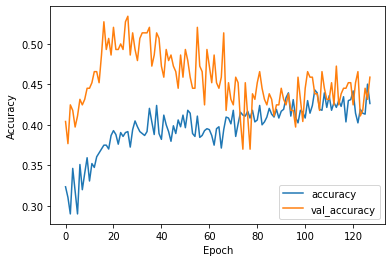

In [19]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

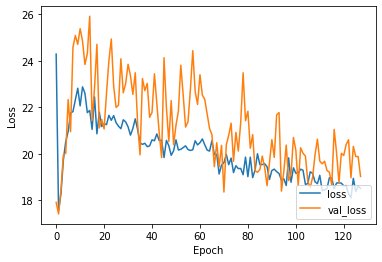

In [20]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

In [21]:
# test = np.array([test_images[0]])
pred = model.predict(test)
true = test_nodelist
# print(pred)
print("Pred")
print((pred).round())
print("True")
print(true)

Pred
[[2. 3. 4. 4. 3. 3. 3.]
 [2. 2. 4. 5. 4. 2. 2.]
 [2. 2. 4. 5. 4. 2. 2.]
 [2. 2. 4. 4. 4. 3. 3.]
 [2. 1. 5. 5. 4. 2. 2.]
 [3. 4. 2. 3. 3. 3. 3.]
 [2. 2. 4. 5. 3. 2. 3.]
 [3. 3. 3. 4. 3. 2. 3.]
 [2. 2. 3. 4. 4. 3. 3.]
 [3. 2. 3. 5. 3. 2. 3.]
 [2. 2. 4. 4. 4. 2. 2.]
 [2. 2. 4. 5. 4. 2. 2.]
 [2. 3. 3. 4. 3. 3. 3.]
 [2. 3. 3. 4. 3. 3. 3.]
 [2. 3. 3. 4. 3. 3. 3.]
 [2. 2. 4. 4. 4. 2. 3.]
 [2. 2. 4. 4. 4. 2. 3.]
 [2. 2. 5. 4. 4. 2. 2.]
 [2. 2. 5. 5. 4. 2. 2.]
 [2. 1. 4. 5. 4. 2. 2.]
 [2. 1. 4. 5. 5. 2. 2.]
 [1. 5. 5. 0. 3. 4. 3.]
 [2. 3. 4. 5. 3. 2. 3.]
 [2. 3. 4. 4. 3. 2. 3.]
 [3. 3. 3. 3. 3. 3. 3.]
 [1. 4. 5. 2. 3. 3. 3.]
 [2. 3. 3. 3. 4. 3. 3.]
 [3. 3. 3. 3. 3. 3. 3.]
 [3. 4. 3. 3. 3. 3. 3.]
 [2. 3. 4. 4. 3. 2. 2.]
 [2. 3. 4. 4. 3. 2. 3.]
 [2. 2. 4. 5. 3. 2. 2.]
 [2. 2. 4. 5. 4. 2. 2.]
 [2. 2. 4. 4. 4. 2. 2.]
 [2. 2. 4. 4. 4. 3. 3.]
 [3. 3. 3. 3. 4. 3. 3.]
 [2. 2. 4. 4. 4. 2. 3.]
 [2. 2. 4. 4. 4. 2. 2.]
 [2. 2. 4. 4. 4. 2. 2.]
 [2. 2. 4. 5. 4. 2. 2.]
 [2. 1. 4. 5. 4. 2. 2.]
 [3. 3. 3. 

In [22]:
# test = np.array([test_images[0]])
pred = model.predict(train[:10])
true = train_nodelist[:10]
# print(pred)
print("Pred")
print((pred).round())
print("True")
print(true)

Pred
[[2. 2. 4. 5. 4. 2. 2.]
 [2. 1. 5. 5. 4. 2. 2.]
 [2. 4. 5. 1. 3. 4. 3.]
 [3. 2. 3. 4. 3. 2. 3.]
 [2. 2. 4. 4. 4. 2. 2.]
 [2. 2. 3. 4. 4. 3. 3.]
 [2. 2. 4. 5. 4. 2. 3.]
 [2. 3. 4. 5. 3. 2. 3.]
 [2. 3. 3. 4. 4. 3. 3.]
 [2. 2. 4. 6. 3. 2. 3.]]
True
[[0. 4. 1. 5. 6. 3. 2.]
 [1. 0. 6. 4. 5. 3. 2.]
 [1. 4. 6. 3. 0. 5. 2.]
 [4. 0. 5. 2. 1. 3. 6.]
 [3. 1. 0. 6. 5. 4. 2.]
 [5. 0. 3. 1. 6. 2. 4.]
 [3. 4. 1. 6. 0. 5. 2.]
 [5. 2. 1. 6. 4. 3. 0.]
 [1. 0. 6. 4. 5. 3. 2.]
 [1. 2. 5. 6. 3. 4. 0.]]
